In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/tmp/ipykernel_3431430/4185135889.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Let's make our first LSTM model

For this experiment we'll be using a random dataset that I found on kaggle that contains a timeseries of various facets of a wind turbine. For our use case we will just look at the wind speed and power generation. This dataset has a 10 minute time frequency and spans over 2 years. I just do some basic data cleaning and then we'll build simple MLP, RNN, and LSTM models to predict the power generation based on the wind speed.

In [2]:
# Data from: https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting?resource=download
df = pd.read_csv('./data/Turbine_Data.csv', index_col=0)
df.index = pd.DatetimeIndex(df.index)
df = df.fillna(-20)
df.head()

vars_of_interest = ['WindSpeed', 'ActivePower']
df = df[vars_of_interest]
train_df = df['2018-01-01':'2018-12-31']
test_df = df['2019-01-01':'2019-12-31']

means = train_df.mean()
stds = train_df.std()

train_df = (train_df - means) / stds
test_df = (test_df - means) / stds


In [3]:
len(train_df), len(test_df)

(52560, 52560)

# First some basic data exploration

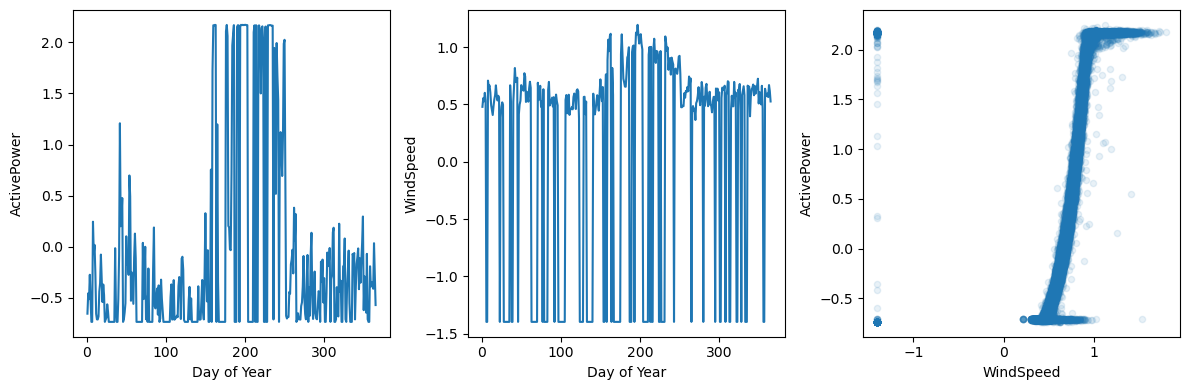

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
train_df['ActivePower'].groupby(train_df.index.dayofyear).median().plot(ax=axes[0])
axes[0].set_ylabel('ActivePower')
axes[0].set_xlabel('Day of Year')
train_df['WindSpeed'].groupby(train_df.index.dayofyear).median().plot(ax=axes[1])
axes[1].set_ylabel('WindSpeed')
axes[1].set_xlabel('Day of Year')
train_df.plot.scatter(x='WindSpeed', y='ActivePower', alpha=0.1, ax=axes[2])
plt.tight_layout()

# Creating a dataset to sample from

In [5]:
class WindDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        # Outputs have dims [window_size, num_features]
        window = self.df.iloc[idx:idx+self.window_size]
        wind_speed = window['WindSpeed'].values.reshape(-1, 1)
        active_power = window['ActivePower'].iloc[-1].reshape(-1, 1)
        x = torch.from_numpy(wind_speed).to(torch.float32)
        y = torch.from_numpy(active_power).to(torch.float32)
        return x, y

In [6]:
window_size = 24
dataset = WindDataset(train_df, window_size)
# Data loader automatically batches and shuffles data, resulting 
# batches have shape [batch_size, window_size, num_features]
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Model definitions

In [31]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input dims for x are [batch_size, window_size, num_features]
        # So flatten for the linear layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        return x
    

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        o, h = self.rnn(x)
        o = F.tanh(o)
        return self.fc(o)[:, -1, :]
    

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        o, (h, c) = self.lstm(x)
        o = F.tanh(o)
        return self.fc(o)[:, -1, :]

# Training the models

In [32]:
mlp = SimpleMLP(24, 64, 1).to(device)
rnn = SimpleRNN(1, 64, 1).to(device)
lstm = SimpleLSTM(1, 64, 1).to(device)

opt_mlp = torch.optim.Adam(mlp.parameters(), lr=3e-3)
opt_rnn = torch.optim.Adam(rnn.parameters(), lr=3e-3)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=3e-3)

loss_fn = nn.MSELoss()

# Train the models
def train_model(model, opt, dataloader, epochs=10, device='cpu'):
    losses = []
    model.train()
    for epoch in range(epochs):
        loss_avg = 0
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y.squeeze())
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_avg += loss.item()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        losses.append(loss_avg / i)
    return losses

In [33]:
mlp_losses = train_model(mlp, opt_mlp, dataloader, device=device)

Epoch 1, Loss: 0.4832075536251068
Epoch 2, Loss: 0.39497536420822144
Epoch 3, Loss: 0.39165860414505005
Epoch 4, Loss: 0.3981419503688812
Epoch 5, Loss: 0.3653441369533539
Epoch 6, Loss: 0.35929906368255615
Epoch 7, Loss: 0.36942559480667114
Epoch 8, Loss: 0.3110923171043396
Epoch 9, Loss: 0.3379642963409424
Epoch 10, Loss: 0.3938668966293335


In [34]:
rnn_losses = train_model(rnn, opt_rnn, dataloader, device=device)

Epoch 1, Loss: 0.16762675344944
Epoch 2, Loss: 0.16170558333396912
Epoch 3, Loss: 0.1441211700439453
Epoch 4, Loss: 0.09739866852760315
Epoch 5, Loss: 0.08805777877569199
Epoch 6, Loss: 0.11801876127719879
Epoch 7, Loss: 0.1102367416024208
Epoch 8, Loss: 0.05528387054800987
Epoch 9, Loss: 0.12258695065975189
Epoch 10, Loss: 0.11150682717561722


In [35]:
lstm_losses = train_model(lstm, opt_lstm, dataloader, device=device)

Epoch 1, Loss: 0.1409602016210556
Epoch 2, Loss: 0.15025275945663452
Epoch 3, Loss: 0.10473079979419708
Epoch 4, Loss: 0.10177810490131378
Epoch 5, Loss: 0.06487024575471878
Epoch 6, Loss: 0.15050108730793
Epoch 7, Loss: 0.10101284086704254
Epoch 8, Loss: 0.08847952634096146
Epoch 9, Loss: 0.04676095023751259
Epoch 10, Loss: 0.07021614164113998


Text(0, 0.5, 'Loss')

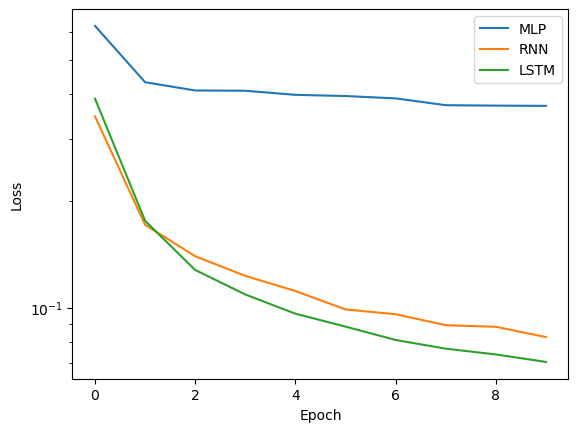

In [36]:
plt.plot(mlp_losses, label='MLP')
plt.plot(rnn_losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.legend()
plt.semilogy()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Now we test the models

In [37]:
# now we can test the models
test_dataset = WindDataset(test_df, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# Convert the data back to original scale (for plotting, not for the model)
test_data = test_df['ActivePower'].values[window_size:] * stds['ActivePower'] + means['ActivePower']

def test_model(model, dataloader):
    model.eval()
    preds = []
    for x, y in dataloader:
        x = x.to(device)
        y_pred = model(x)
        preds.append(y_pred.cpu().detach().numpy())
    return np.array(preds).squeeze()


In [38]:
mlp_preds = test_model(mlp, test_dataloader)
mlp_preds = mlp_preds * stds['ActivePower'] + means['ActivePower']

In [39]:
rnn_preds = test_model(rnn, test_dataloader)
rnn_preds = rnn_preds * stds['ActivePower'] + means['ActivePower']

In [40]:
lstm_preds = test_model(lstm, test_dataloader)
lstm_preds = lstm_preds * stds['ActivePower'] + means['ActivePower']

Text(0.5, 0, 'Time')

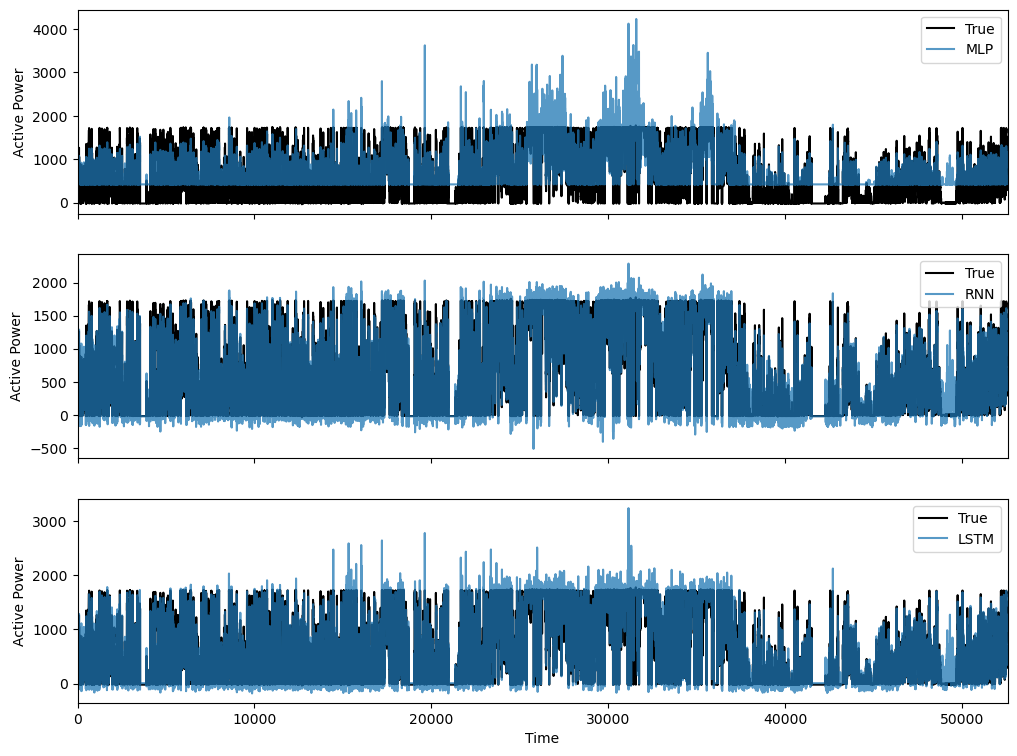

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
axes[0].plot(test_data, label='True', color='black')
axes[0].plot(mlp_preds, label='MLP', alpha=0.75)

axes[1].plot(test_data, label='True', color='black')
axes[1].plot(rnn_preds, label='RNN', alpha=0.75)

axes[2].plot(test_data, label='True', color='black')
axes[2].plot(lstm_preds, label='LSTM', alpha=0.75)

for ax in axes:
    ax.legend()
    ax.set_ylabel('Active Power')
    ax.set_xlim(0, 6 * 24 * 365)
axes[-1].set_xlabel('Time')

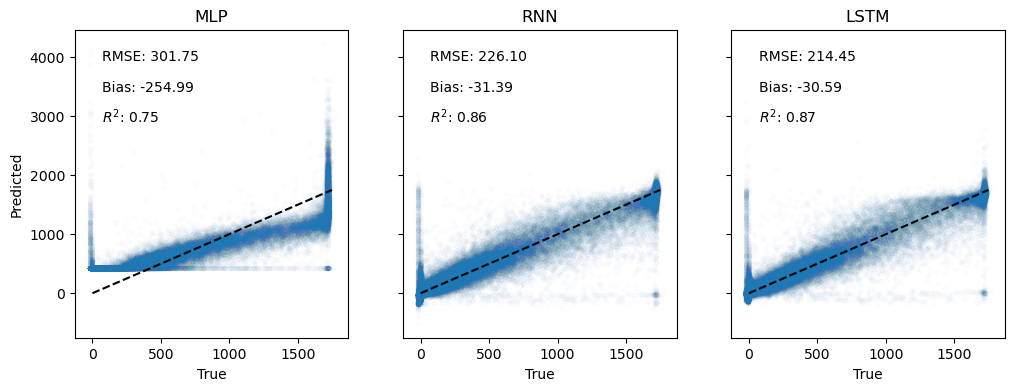

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for ax, preds, name in zip(axes, [mlp_preds, rnn_preds, lstm_preds], ['MLP', 'RNN', 'LSTM']):
    ax.scatter(test_data, preds, alpha=0.01, marker='.')
    ax.plot([0, 1750], [0, 1750], color='black', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel('True')

axes[0].set_ylabel('Predicted')


def calculate_metrics(true, preds):
    # Calculate the RMSE, Percent Bias, and R^2
    true = np.copy(true)
    preds = np.copy(preds)
    preds = preds[true>1]
    true = true[true>1]
    rmse = np.sqrt(np.mean((true - preds)**2))
    r2 = 1 - np.sum((true - preds)**2) / np.sum((true - np.mean(true))**2)
    bias = np.mean((true - preds) / true) * 100
    return rmse, bias, r2

mlp_metrics = calculate_metrics(test_data, mlp_preds)
rnn_metrics = calculate_metrics(test_data, rnn_preds)
lstm_metrics = calculate_metrics(test_data, lstm_preds)

# Add metrics as text to the plot
for ax, metrics, name in zip(axes, [mlp_metrics, rnn_metrics, lstm_metrics], ['MLP', 'RNN', 'LSTM']):
    ax.text(0.1, 0.9, f'RMSE: {metrics[0]:.2f}', transform=ax.transAxes)
    ax.text(0.1, 0.8, f'Bias: {metrics[1]:.2f}', transform=ax.transAxes)
    ax.text(0.1, 0.7, f'$R^2$: {metrics[2]:.2f}', transform=ax.transAxes)